# Visualization

This jupyter notebook visualizes the dynamical model learned by the [Graph Dynamical Networks](https://arxiv.org/abs/1902.06836) (GDyNets). It uses the toy system from the [paper](https://arxiv.org/abs/1902.06836) as an example to demonstrate how to visualize the results learned by the model. One should be able to apply this notebook to other datasets with very minor changes.

## Prerequisites

Before running this notebook, you need to first train a GDyNets model using the toy system.

First, download the preprocessed data files `li2s-traj-graph-train.npz`, `li2s-traj-graph-val.npz`, `li2s-traj-graph-test.npz` for the toy system from [Link], and save them in the `data` folder.

Then, train a GDyNets model with the following command.

```
python main.py --train-flist data/li2s-traj-graph-train.npz --val-flist data/li2s-traj-graph-val.npz --test-flist data/li2s-traj-graph-test.npz --mode direct --tau 1 --n-classes 2 --atom-fea-len 16 --n-conv 2 --lr 0.0005 --batch-size 10240 --n-epoch 30
```

Once the training completes, you are ready to run this notebook.

Import libraries.

In [1]:
import os
import numpy as np
from gdynet.model import GDyNet
from gdynet.postprocess import plot_timescales, plot_ck_tests

%matplotlib inline
import matplotlib.pyplot as plt

Define parameters. The parameters should be the same as those used during the training.

In [2]:
params = {
    'train_flist': ['./data/li2s-traj-graph-train.npz'],
    'val_flist': ['./data/li2s-traj-graph-val.npz'],
    'test_flist': ['./data/li2s-traj-graph-test.npz'],
    'job_dir': './',
    'mode': 'direct',
    'tau': 1,
    'n_classes': 2,
    'k_eig': 0,
    'atom_fea_len': 16,
    'n_conv': 2,
    'learning_rate': 0.0005,
    'batch_size': 10240,
    'use_bn': True,
    'n_epoch': 30,
    'shuffle': True,
    'random_seed': 123,
}

gdynet = GDyNet(**params)

Plot the training curves. The training has three stages: 1) minimize VAMP-2 loss; 2) minimize VAMP-1 loss; 3) minimize VAMP-2 loss. The reason for choosing such a training scheme can be found in the [VAMPnets paper](https://www.nature.com/articles/s41467-017-02388-1).

In [4]:
import pandas as pd

train_logs = []
for i in range(3):
    train_logs.append(pd.read_csv(os.path.join(params['job_dir'], 'train_{}.log'.format(i))))

#     try:
#     except FileNotFoundError:
#         pass
train_logs = pd.concat(train_logs, ignore_index=True)

<AxesSubplot:>

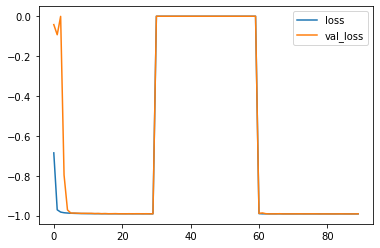

In [5]:
train_logs.plot.line(y=['loss', 'val_loss'])

<AxesSubplot:>

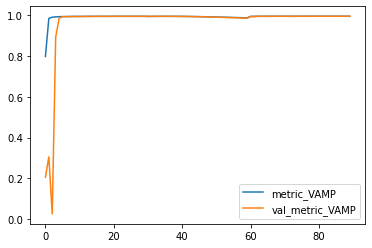

In [6]:
train_logs.plot.line(y=['metric_VAMP', 'val_metric_VAMP'])

<AxesSubplot:>

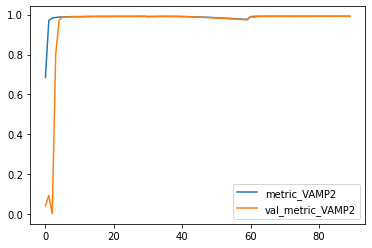

In [7]:
train_logs.plot.line(y=['metric_VAMP2', 'val_metric_VAMP2'])

Load the predicted state probabilities of the test dataset.

In [8]:
preds = np.load(os.path.join(params['job_dir'], 'test_pred.npy'))

# preds has shape (num_trajs, num_frames, num_atoms, n_classes)
preds.shape

(1, 1000000, 1, 2)

Reshape the state probabilities. The trajectory and atom dimensions are combined because we assume they are both independent.

In [9]:
preds = np.transpose(preds, (1, 0, 2, 3))

F = preds.shape[0]
preds = preds.reshape(F, -1, params['n_classes'])

# preds has shape (num_frames, batch, n_classes)
preds.shape

(1000000, 1, 2)

Plot the populations of each state.

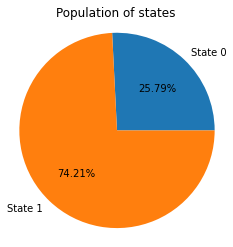

In [10]:
probs = np.sum(preds, axis=(0, 1))
probs = probs / np.sum(probs)
labels = ['State {}'.format(i) for i in range(len(probs))]
plt.figure()
plt.pie(probs, labels=labels, autopct='%1.2f%%')
plt.axis("image")
plt.title('Population of states')
plt.show()

Plot the relaxation timescales. The relaxation timescales represent the characteristic timescales implied by the transition matrix at a specified lag time. We plot how the relaxation timescales change as a function of the lag time. Once the relaxation timescales stops to change, the model start to follow the Markovian assumption. `lag` is an array of lag times at which we compute the relaxation timescales. We split the data to `n_splits` parts along the time axis `split_axis` to estimate the uncertainty. `time_unit_in_ns` converts the timesteps into the unit of `ns`.

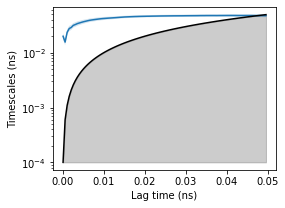

In [11]:
max_tau = 500
time_unit_in_ns = 1e-4
lag = np.arange(1, max_tau, 5)
plot_timescales(preds, lag, n_splits=5, split_axis=0, time_unit_in_ns=time_unit_in_ns)

Perform CK test. In the above figure, we know that starting at `0.01 ns`, the model start to follow the Markovian assumption. So the transition matrix with lag time `tau_msm = 100` (`0.01 ns`) should pass the CK test. We perform the CK test with `tau_msm = 100`. The values predicted by direct multiplication the transition (blue) and estimated from the trajectory data (red) match very well. Note that we should choose the smallest `tau_msm` because it provide the most detailed dynamica information.

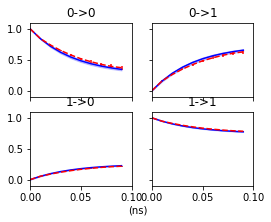

In [12]:
tau_msm = 100
plot_ck_tests(preds, tau_msm=100, steps=10, n_splits=5, split_axis=0, time_unit_in_ns=time_unit_in_ns)

Perform eigenvalue decomposition to the Koopman matrix (`koopman_op`)

In [13]:
koopman_op = gdynet.vamp.estimate_koopman_op(preds, tau_msm)
eigvals, eigvecs = np.linalg.eig(koopman_op.T)

In [14]:
def plot_eigvals(eigvals):
    plt.figure(figsize=(4, 4))
    plt.bar(range(len(eigvals)), eigvals, width=0.4)
    plt.xticks(range(len(eigvals)))
    plt.xlabel('States')
    plt.ylabel('Eigvectors')

Plot the eigenvectors corresponding to each relaxation. The largest eigenvalue should be `1` with relaxation timescale of infinity. The unrealistic timescale here is due to numerical errors. The second eigenvector shows the transition between octahedral and tetrahedral sites.

Eig 1
Value: 0.9999997
Timescale: 33554.42880000031 ns
Vector: [-0.32579353 -0.94544095]
Eig 0
Value: 0.78985226
Timescale: 0.04238916476456466 ns
Vector: [-0.707102    0.70711154]


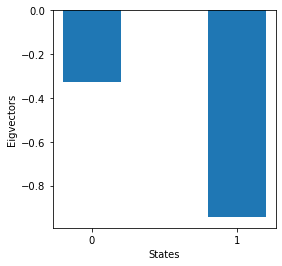

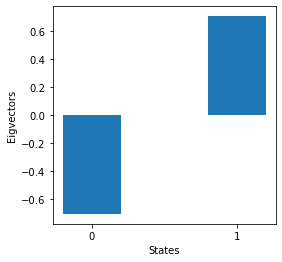

In [15]:
for i, eigval in sorted(enumerate(eigvals), key=lambda x: x[1], reverse=True):
    print('Eig {}'.format(i))
    print('Value:', eigval)
    print('Timescale: {} ns'.format(-tau_msm / np.log(np.abs(eigval)) * time_unit_in_ns))
    print('Vector:', eigvecs[:, i])
    plot_eigvals(eigvecs[:, i])

plt.show()

Now, we want to visualize the probability distribution of the states in 3D space. First, we load the trajectories.

In [16]:
with np.load(params['test_flist'][0]) as data:
    traj_coords = data['traj_coords']
traj_coords.shape

(1000000, 5, 3)

Finally, we plot the probability of being in each state in the 3D space.

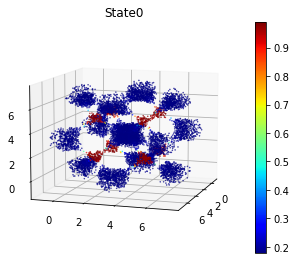

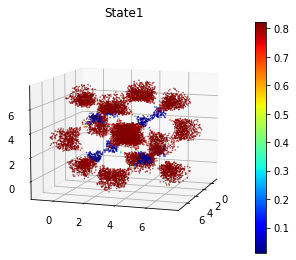

In [19]:
import matplotlib
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D

def scatter3d(x,y,z, cs, title, colorsMap='jet', angle=30):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure(figsize=(4.2, 3.2))
    ax = Axes3D(fig)
    ax.axis('auto')
    ax.scatter(x, y, z, s=1, c=scalarMap.to_rgba(cs), marker='.', alpha=0.8)
    scalarMap.set_array(cs)
    ax.view_init(10, angle)
    fig.colorbar(scalarMap)
    plt.title(title)
    plt.show()

for i in range(params['n_classes']):
    scatter3d(traj_coords[::100, 0, 0], traj_coords[::100, 0, 1], traj_coords[::100, 0, 2],
              cs=preds.reshape(-1, params['n_classes'])[::100, i], title='State' + str(i),
              angle=18)